In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT



This notebook is derived from RunModel_Demo_28November2020-SimpleCNNLayer_Ca which "worked", but did not reach as high efficiency as earlier models. Here, the number of hidden convolutional layers is increased by 2 and the number of output channels per layer is increased by using SimpleCNN7Layer_Ca_Two_KDE in place of SimpleCNN5Layer_Ca_Two_KDE

The goal is to use two channels of input -- poca_KDE_A and poca_KDE_B to see if this improves the performance of the algorithm, all else being equal.

"withPfc" denotes using poca_KDE_A_xMax & poca_KDE_A_yMax as perturbative features

We use full LHCb MC for both training and validation here, albeit a training sample slightly less than 100K events.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Fri Dec 18 21:52:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   37C    P8    23W / 250W |   5572MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 50

# Name is the output file name


##  201128  mds
##  iter2 follows from iter0 (only last layer weights allowed to be learned)
##  due to operator error, the file/folder name was iter1 rather than iter2
##  so the labeling is slightly mis-leading.  This is the first iteration
##  when all weights are allowed to vary
folder = '18December2020_AllCNN8Layer_withPcnn_50epochs_moreDataIter1_lr_5em7_aymm_15p0'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 128

# How fast to learn
learning_rate = 5e-7

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below


from model.models_mds_G import AllCNN8Layer_Ca_Two_KDE_withPcnn as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
##  added dataAA/pv_HLT1CPU_D0piMagUp_12Dec.h5  201212

##  pv_HLT1CPU_D0piMagUp_12Dec.h5 + pv_HLT1CPU_MinBiasMagDown_14Nov.h5 contain 138810 events
##  pv_HLT1CPU_MinBiasMagUp_14Nov.h5 contains 51349
##  choose which to "load" and slices to produce 180K event training sample
##   and 10159 event validation sample
train_loader = collect_data_poca(
                              'dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5',
                              'dataAA/pv_HLT1CPU_JpsiPhiMagDown_12Dec.h5',
                              'dataAA/pv_HLT1CPU_D0piMagUp_12Dec.h5',
                              'dataAA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5',
                               slice = slice(None,260000),
##                             device = device,
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_A_and_B = True,
                            load_xy=True)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data_poca(
##                          'dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5',
                            'dataAA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5',
##                            'dataAA/pv_HLT1CPU_D0piMagUp_12Dec.h5',
                          batch_size=batch_size,
                          slice=slice(33000,None),
##                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_A_and_B = True,
                          load_xy=True)

Loading data...
Loaded dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5 in 18.33 s
Loaded dataAA/pv_HLT1CPU_JpsiPhiMagDown_12Dec.h5 in 30.94 s
Loaded dataAA/pv_HLT1CPU_D0piMagUp_12Dec.h5 in 30.54 s
Loaded dataAA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5 in 18.05 s
Constructing 260000 event dataset took 2.01 s
Loading data...
Loaded dataAA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5 in 18.14 s
Constructing 18349 event dataset took 0.1859 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=15.0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  1    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  2    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  3    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  4    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  5    Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  6    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  7    Dropout(p=0.15, inplace=False)
ct, child =  8    Dropout(p=0.15, inplace=False)
ct, child =  9    Dropout(p=0.15, inplace=False)
ct, child =  10    Dropout(p=0.15, inplace=False)
ct, child =  11    Dropout(p=0.15, inplace=False)
ct, child =  12    Dropout(p=0.15, inplace=False)
ct, child =  13    Dropout(p=0.15, inplace=False)
ct, child =  14    Linear(in_features=4000, out_features=4000, bias=True)
ct, child =  15    Conv1d(1,

In [11]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [12]:
##print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
## not that m1p0 in file name is mis-leading  201212
oldName = '18December2020_AllCNN8Layer_withPcnn_50epochs_moreDataIter1_lr_5em7_aymm_10p0'
oldFolder = oldName
suffix = 'final'
dictName = 'ML/'+oldFolder+'/'+oldName+'_'+suffix+'.pyt'
print('dictName = ',dictName)
pretrained_dict = torch.load(dictName)
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
print(" \n","  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
## mds  

print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
## print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


dictName =  ML/18December2020_AllCNN8Layer_withPcnn_50epochs_moreDataIter1_lr_5em7_aymm_10p0/18December2020_AllCNN8Layer_withPcnn_50epochs_moreDataIter1_lr_5em7_aymm_10p0_final.pyt
for model_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9    conv5.bias
index, k =   10    conv6.weight
index, k =   11    conv6.bias
index, k =   12    conv7.weight
index, k =   13    conv7.bias
index, k =   14    fc1.weight
index, k =   15    fc1.bias
index, k =   16    finalFilter.weight
index, k =   17    finalFilter.bias
index, k =   18    ppConv1.weight
index, k =   19    ppConv1.bias
index, k =   20    ppConv2.weight
index, k =   21    ppConv2.bias
index, k =   22    ppConv3.weight
index, k =   23    ppConv3.bias
index, k =   24    ppFc1.weight
index, k =   25   

<All keys matched successfully>

In [13]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


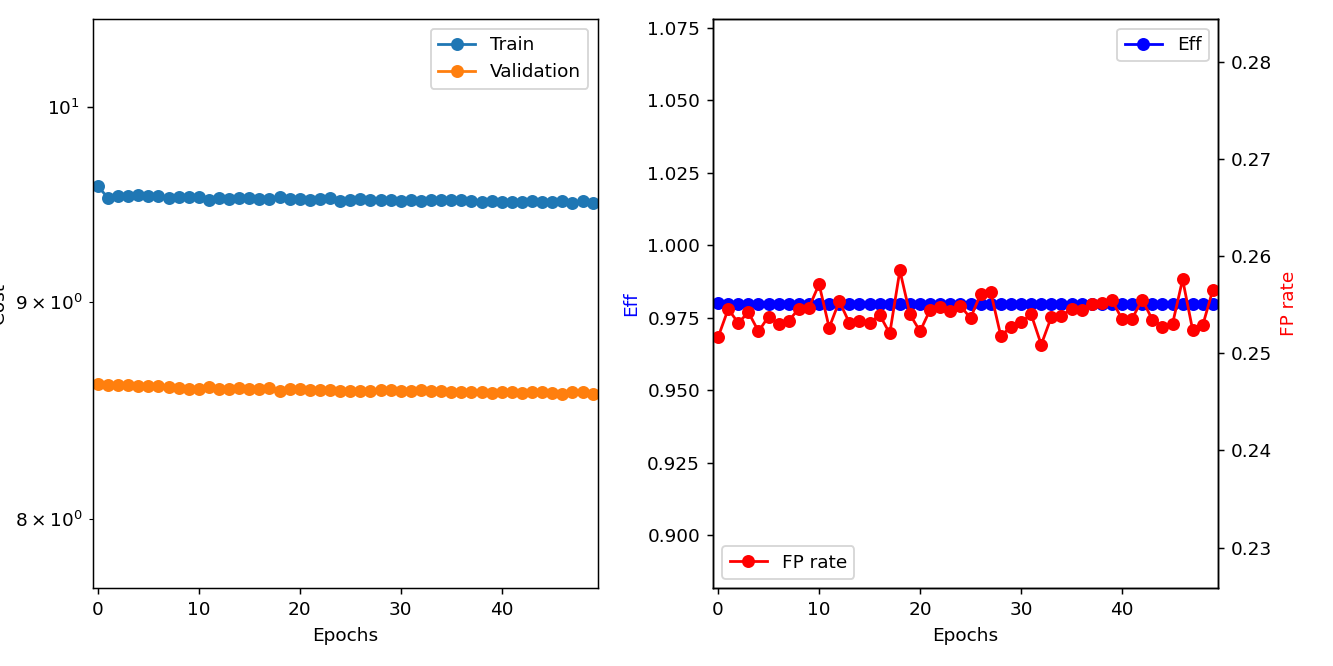

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 2032, val = 144


x0 =  tensor([[2.0562e-33, 3.3589e-30, 1.6231e-28,  ..., 1.5498e-17, 1.4611e-14,
         7.4538e-09],
        [7.5554e-21, 2.9710e-23, 4.7560e-27,  ..., 5.8011e-17, 1.6164e-18,
         4.2498e-11],
        [1.3985e-20, 5.5533e-19, 1.8861e-15,  ..., 2.1064e-15, 2.0252e-15,
         1.4246e-17],
        ...,
        [1.9662e-27, 4.6398e-29, 1.4883e-27,  ..., 2.8439e-12, 8.6544e-15,
         2.8287e-16],
        [6.4784e-39, 4.1614e-38, 2.0879e-38,  ..., 1.0742e-19, 7.3741e-17,
         3.7921e-16],
        [1.1717e-28, 3.2235e-32, 1.5291e-35,  ..., 2.1126e-20, 1.5597e-17,
         1.6725e-15]], device='cuda:0', grad_fn=<SoftplusBackward>)
x1 =  tensor([[ 0.0616,  0.0446,  0.0305,  ..., -0.0374, -0.0123,  0.0115],
        [-0.0169, -0.0620, -0.1038,  ..., -0.0592, -0.0271,  0.0051],
        [ 0.0948,  0.0932,  0.0919,  ..., -0.0691, -0.0383, -0.0017],
        ...,
        [ 0.0788,  0.0728,  0.0673,  ..., -0.0095,  0.0088,  0.0236],
        [ 0.0147, -0.0199, -0.0550,  ..., -0.0739, -0.

Epoch 1: train=9.52289, val=8.60366, took 97.255 s
  Validation Found 91988 of 93880, added 4671 (eff 97.98%) (0.255 FP/event)


Epoch 2: train=9.53385, val=8.60232, took 94.596 s
  Validation Found 91987 of 93880, added 4645 (eff 97.98%) (0.253 FP/event)


Epoch 3: train=9.53384, val=8.60256, took 94.123 s
  Validation Found 91988 of 93880, added 4665 (eff 97.98%) (0.254 FP/event)


Epoch 4: train=9.53528, val=8.60095, took 94.823 s
  Validation Found 91984 of 93880, added 4629 (eff 97.98%) (0.252 FP/event)


Epoch 5: train=9.53013, val=8.59916, took 94.619 s
  Validation Found 91982 of 93880, added 4657 (eff 97.98%) (0.254 FP/event)


Epoch 6: train=9.53121, val=8.59862, took 95.416 s
  Validation Found 91983 of 93880, added 4643 (eff 97.98%) (0.253 FP/event)


Epoch 7: train=9.52105, val=8.59318, took 95.352 s
  Validation Found 91980 of 93880, added 4649 (eff 97.98%) (0.253 FP/event)


Epoch 8: train=9.52743, val=8.59041, took 95.09 s
  Validation Found 91979 of 93880, added 4672 (eff 97.98%) (0.255 FP/event)


Epoch 9: train=9.52772, val=8.58677, took 95.186 s
  Validation Found 91982 of 93880, added 4674 (eff 97.98%) (0.255 FP/event)


Epoch 10: train=9.52766, val=8.58622, took 94.65 s
  Validation Found 91981 of 93880, added 4718 (eff 97.98%) (0.257 FP/event)


Epoch 11: train=9.51078, val=8.59257, took 94.88 s
  Validation Found 91982 of 93880, added 4636 (eff 97.98%) (0.253 FP/event)


Epoch 12: train=9.51926, val=8.58512, took 95.379 s
  Validation Found 91978 of 93880, added 4686 (eff 97.97%) (0.255 FP/event)


Epoch 13: train=9.5184, val=8.58593, took 94.901 s
  Validation Found 91975 of 93880, added 4645 (eff 97.97%) (0.253 FP/event)


Epoch 14: train=9.52029, val=8.58817, took 95.211 s
  Validation Found 91973 of 93880, added 4648 (eff 97.97%) (0.253 FP/event)


Epoch 15: train=9.51996, val=8.58772, took 95.081 s
  Validation Found 91978 of 93880, added 4645 (eff 97.97%) (0.253 FP/event)


Epoch 16: train=9.51396, val=8.58577, took 95.152 s
  Validation Found 91976 of 93880, added 4660 (eff 97.97%) (0.254 FP/event)


Epoch 17: train=9.51522, val=8.58809, took 95.728 s
  Validation Found 91977 of 93880, added 4625 (eff 97.97%) (0.252 FP/event)


Epoch 18: train=9.52539, val=8.57812, took 95.211 s
  Validation Found 91976 of 93880, added 4744 (eff 97.97%) (0.259 FP/event)


Epoch 19: train=9.51387, val=8.58437, took 95.044 s
  Validation Found 91972 of 93880, added 4661 (eff 97.97%) (0.254 FP/event)


Epoch 20: train=9.51812, val=8.58346, took 95.235 s
  Validation Found 91971 of 93880, added 4629 (eff 97.97%) (0.252 FP/event)


Epoch 21: train=9.51339, val=8.58219, took 95.064 s
  Validation Found 91970 of 93880, added 4670 (eff 97.97%) (0.254 FP/event)


Epoch 22: train=9.51641, val=8.57937, took 95.543 s
  Validation Found 91969 of 93880, added 4675 (eff 97.96%) (0.255 FP/event)


Epoch 23: train=9.51944, val=8.57966, took 95.252 s
  Validation Found 91974 of 93880, added 4668 (eff 97.97%) (0.254 FP/event)


Epoch 24: train=9.50698, val=8.57774, took 95.498 s
  Validation Found 91967 of 93880, added 4677 (eff 97.96%) (0.255 FP/event)


Epoch 25: train=9.51105, val=8.5783, took 95.535 s
  Validation Found 91969 of 93880, added 4654 (eff 97.96%) (0.254 FP/event)


Epoch 26: train=9.5146, val=8.57652, took 95.118 s
  Validation Found 91975 of 93880, added 4700 (eff 97.97%) (0.256 FP/event)


Epoch 27: train=9.51289, val=8.5744, took 95.018 s
  Validation Found 91977 of 93880, added 4703 (eff 97.97%) (0.256 FP/event)


Epoch 28: train=9.51069, val=8.5794, took 95.274 s
  Validation Found 91967 of 93880, added 4620 (eff 97.96%) (0.252 FP/event)


Epoch 29: train=9.50896, val=8.579, took 95.312 s
  Validation Found 91964 of 93880, added 4638 (eff 97.96%) (0.253 FP/event)


Epoch 30: train=9.50801, val=8.57812, took 95.143 s
  Validation Found 91970 of 93880, added 4646 (eff 97.97%) (0.253 FP/event)


Epoch 31: train=9.51003, val=8.57524, took 95.232 s
  Validation Found 91971 of 93880, added 4661 (eff 97.97%) (0.254 FP/event)


Epoch 32: train=9.50706, val=8.58268, took 96.683 s
  Validation Found 91962 of 93880, added 4604 (eff 97.96%) (0.251 FP/event)


Epoch 33: train=9.51332, val=8.57612, took 95.431 s
  Validation Found 91969 of 93880, added 4656 (eff 97.96%) (0.254 FP/event)


Epoch 34: train=9.51349, val=8.57814, took 95.709 s
  Validation Found 91968 of 93880, added 4658 (eff 97.96%) (0.254 FP/event)


Epoch 35: train=9.50928, val=8.57328, took 95.402 s
  Validation Found 91970 of 93880, added 4672 (eff 97.97%) (0.255 FP/event)


Epoch 36: train=9.51165, val=8.57252, took 95.83 s
  Validation Found 91967 of 93880, added 4670 (eff 97.96%) (0.254 FP/event)


Epoch 37: train=9.50703, val=8.57225, took 95.146 s
  Validation Found 91972 of 93880, added 4680 (eff 97.97%) (0.255 FP/event)


Epoch 38: train=9.49951, val=8.57087, took 94.885 s
  Validation Found 91975 of 93880, added 4683 (eff 97.97%) (0.255 FP/event)


Epoch 39: train=9.50682, val=8.56806, took 95.413 s
  Validation Found 91969 of 93880, added 4688 (eff 97.96%) (0.255 FP/event)


Epoch 40: train=9.50037, val=8.57175, took 96.099 s
  Validation Found 91970 of 93880, added 4652 (eff 97.97%) (0.254 FP/event)


Epoch 41: train=9.50081, val=8.5726, took 95.071 s
  Validation Found 91973 of 93880, added 4653 (eff 97.97%) (0.254 FP/event)


Epoch 42: train=9.50298, val=8.56741, took 95.063 s
  Validation Found 91975 of 93880, added 4689 (eff 97.97%) (0.256 FP/event)


Epoch 43: train=9.50375, val=8.57192, took 95.382 s
  Validation Found 91969 of 93880, added 4651 (eff 97.96%) (0.253 FP/event)


Epoch 44: train=9.50069, val=8.57011, took 95.158 s
  Validation Found 91973 of 93880, added 4638 (eff 97.97%) (0.253 FP/event)


Epoch 45: train=9.50059, val=8.56869, took 95.473 s
  Validation Found 91972 of 93880, added 4643 (eff 97.97%) (0.253 FP/event)


Epoch 46: train=9.50445, val=8.56441, took 95.073 s
  Validation Found 91974 of 93880, added 4727 (eff 97.97%) (0.258 FP/event)


Epoch 47: train=9.49462, val=8.56978, took 95.158 s
  Validation Found 91972 of 93880, added 4631 (eff 97.97%) (0.252 FP/event)


Epoch 48: train=9.50497, val=8.57032, took 95.347 s
  Validation Found 91971 of 93880, added 4641 (eff 97.97%) (0.253 FP/event)


Epoch 49: train=9.49563, val=8.56315, took 95.009 s
  Validation Found 91979 of 93880, added 4708 (eff 97.98%) (0.257 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [16]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [17]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/data/conda/envs/goofit/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


Save the plot above:

<IPython.core.display.Javascript object>


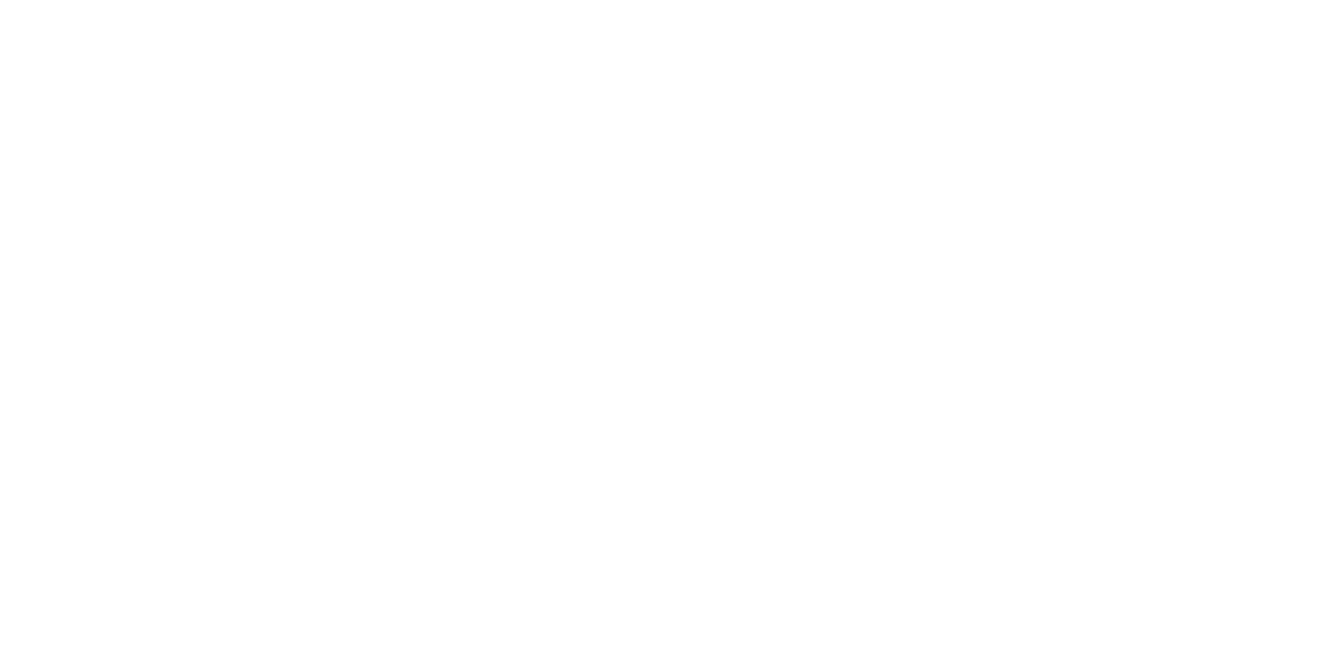

In [18]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [19]:
quit()